In [202]:
import os
import numpy as np
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from scout import segment
from scout import io
from scout.niche import randomly_sample

In [2]:
working_dir = '/data/datasets/ventricle_segmentation/'
os.listdir(working_dir)

['seg_d35_3.tif',
 'original_data',
 'unet_weights2.h5',
 'augmented',
 'unet_weights.h5',
 'unet_weights3_zika.h5',
 'unet_weights3.h5',
 'padded_data',
 'unet.h5']

In [3]:
model = segment.load_keras_model(os.path.join(working_dir, 'unet_weights3_zika.h5'))

W1108 12:21:11.933071 140261654554432 deprecation.py:506] From /home/jswaney/.conda/envs/scout/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [5]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 1 160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 1 64          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 1 2320        batch_normalization[0][0]        
______________________________________________________________________________________________

## Define performance metrics

In [8]:
def dice_coef(y_true, y_pred, smooth=100):
    intersection = np.sum((y_true * y_pred).reshape((len(y_true), -1)), axis=-1)
    sum_ = np.sum(y_true.reshape((len(y_true), -1)), axis=-1) + np.sum(y_pred.reshape((len(y_pred), -1)), axis=-1)
    return (2 * intersection + smooth) / (sum_ + smooth)

In [9]:
def roc(y_pred, y_true, threshold):
    y_pred_binary = (y_pred > threshold)

    tp_img = np.logical_and(y_pred_binary, y_true)
    fp_img = np.logical_and(y_pred_binary, np.logical_not(y_true))
    tn_img = np.logical_and(np.logical_not(y_pred_binary), np.logical_not(y_true))
    fn_img = np.logical_and(np.logical_not(y_pred_binary), y_true)

    tp = tp_img.sum()
    fp = fp_img.sum()
    tn = tn_img.sum()
    fn = fn_img.sum()
    
    fpr = fp / (fp + tn)
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)

    return fpr, recall, precision

In [10]:
def fscore(roc_curve):
    return 2 * roc_curve[:, 1] * roc_curve[:, 2] / (roc_curve[:, 1] + roc_curve[:, 2])

## Get test data

In [45]:
padded_dir = os.path.join(working_dir, 'padded_data')
filenames = os.listdir(padded_dir)
paths = [os.path.join(working_dir, 'padded_data', f) for f in filenames]

syto_paths = [p for p in paths if 'syto' in os.path.basename(p)]
seg_paths = [p for p in paths if 'seg' in os.path.basename(p)]

# syto_d35_paths = [p for p in syto_paths if 'd35' in p]
# seg_d35_paths = [p for p in seg_paths if 'd35' in p]

# syto_d60_paths = [p for p in syto_paths if 'd60' in p]
# seg_d60_paths = [p for p in seg_paths if 'd60' in p]

# syto_zika_paths = [p for p in syto_paths if 'zika' in p]
# seg_zika_paths = [p for p in seg_paths if 'zika' in p]

syto_paths.sort()
seg_paths.sort()

seg_paths

['/data/datasets/ventricle_segmentation/padded_data/seg_d35_1.tif',
 '/data/datasets/ventricle_segmentation/padded_data/seg_d35_2.tif',
 '/data/datasets/ventricle_segmentation/padded_data/seg_d35_3.tif',
 '/data/datasets/ventricle_segmentation/padded_data/seg_d35_4.tif',
 '/data/datasets/ventricle_segmentation/padded_data/seg_d60_1.tif',
 '/data/datasets/ventricle_segmentation/padded_data/seg_d60_2.tif',
 '/data/datasets/ventricle_segmentation/padded_data/seg_zika2.tif',
 '/data/datasets/ventricle_segmentation/padded_data/seg_zika3.tif',
 '/data/datasets/ventricle_segmentation/padded_data/seg_zika4.tif']

In [46]:
shapes = np.asarray([io.imread(path).shape for path in tqdm(seg_paths, total=len(seg_paths))])

target_shape = shapes.max(axis=0)
print(f"Target shape after padding: {target_shape}")

x_shape = (shapes[:, 0].sum(), *target_shape[1:])
print(f"Overall shape: {x_shape}")

Target shape after padding: [1500  894  894]
Overall shape: (7596, 894, 894)


In [47]:
zstart = np.asarray([0] + list(np.cumsum(shapes[:, 0])))
zstop = zstart[1:]

x = np.empty(x_shape, np.float32)
y = np.empty(x_shape, np.float32)
for i, (syto_path, seg_path) in tqdm(enumerate(zip(syto_paths, seg_paths)), total=len(seg_paths)):
    x[zstart[i]:zstop[i]] = io.imread(syto_path)
    y[zstart[i]:zstop[i]] = io.imread(seg_path)
    
x.shape, y.shape, x.dtype, y.dtype, x.max(), y.max()

((7596, 894, 894),
 (7596, 894, 894),
 dtype('float32'),
 dtype('float32'),
 10.893618,
 10266.211)

In [50]:
_, x_test, _, y_test = train_test_split(x, y, test_size=0.20, random_state=76)

x_test.shape, y_test.shape

((1520, 894, 894), (1520, 894, 894))

In [51]:
y_pred = segment.segment_ventricles_keras(model, x_test, t=0.5)
y_pred.shape

100%|██████████| 1520/1520 [01:11<00:00, 21.16it/s]


(1520, 894, 894)

In [61]:
y_true = (y_test > 1).astype(np.float32)

In [62]:
(y_pred == y_true).sum() / y_true.size

0.9998123059495503

In [64]:
dice = dice_coef(y_true, y_pred)
dice.shape

(1520,)

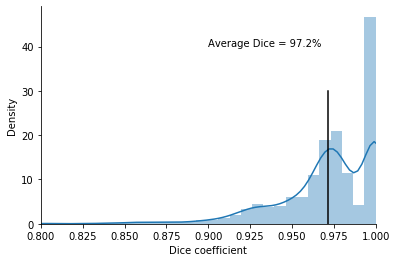

In [200]:
plt.figure()
sns.distplot(dice)
plt.plot(2 * [dice.mean()], [0, 30], 'k-')
plt.annotate(f'Average Dice = {dice.mean()*100:.1f}%', xy=(0.9, 40))
plt.xlim([0.8, 1])
plt.xlabel('Dice coefficient')
plt.ylabel('Density')
sns.despine()
plt.savefig(os.path.join(working_dir, 'ventricle_unet_dice_distribution.pdf'), bbox_inches='tight')
plt.show()

In [132]:
n_samples = 40

x_test_sample, y_true_sample = randomly_sample(n_samples, x_test, y_true)
x_test_sample.shape

(40, 894, 894)

In [133]:
def threshold_sweep(x, ts):
    return np.asarray([segment.segment_ventricles_keras(model, x, t=t) for t in ts])

In [134]:
ts = np.linspace(0, 1, 100)

In [135]:
y_pred_sweeps = threshold_sweep(x_test_sample, ts)
y_pred_sweeps.shape

100%|██████████| 40/40 [00:01<00:00, 24.26it/s]


(100, 40, 894, 894)

In [136]:
y_true_sweeps = np.tile(y_true_sample[np.newaxis], (len(ts), 1, 1, 1))

y_true_sweeps.shape, y_pred_sweeps.shape

((100, 40, 894, 894), (100, 40, 894, 894))

In [137]:
roc_curve = np.asarray([roc(yp, yt, t) for yp, yt, t in zip(y_pred_sweeps, y_true_sweeps, ts)])
roc_curve.shape

/home/jswaney/.conda/envs/scout/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in long_scalars
  app.launch_new_instance()


(100, 3)

In [138]:
roc_curve[0, -1] = 0
roc_curve[-1, -1] = 1

In [155]:
auc = 0
for i in range(len(roc_curve)-1):
    left = roc_curve[i, 1:]
    right = roc_curve[i+1, 1:]
    dx = np.abs(right[0] - left[0])
    h = (left[1] + right[1]) / 2
    auc += dx * h
auc

0.992696166918098

In [165]:
fscore = 2 * roc_curve[:, 1] * roc_curve[:, 2] / (roc_curve[:, 1] + roc_curve[:, 2])
max_idx = np.argmax(fscore)
max_fscore = fscore[max_idx]
max_fscore

0.9734674591946857

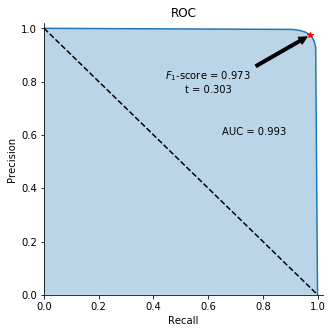

In [199]:
# fpr, recall, precision
plt.figure(figsize=(5, 5))

sns.lineplot(roc_curve[:, 1], roc_curve[:, 2])

plt.plot([roc_curve[max_idx, 1]], [roc_curve[max_idx, 2]], 'r*')
plt.plot([0, 1], [1, 0], 'k--')
plt.fill_between(roc_curve[:, 1], roc_curve[:, 2], alpha=0.3)
plt.annotate(f'AUC = {auc:.3f}', xy=(0.65, 0.6))
plt.annotate(f'$F_1$-score = {max_fscore:.3f}\nt = {ts[max_idx]:.3f}', xy=(roc_curve[max_idx, 1], roc_curve[max_idx, 2]), xycoords='data',
                xytext=(0.6, 0.8), textcoords='data',
                arrowprops=dict(facecolor='black', shrink=0.05, width=3, headwidth=8, headlength=8),
                horizontalalignment='center', verticalalignment='center',
                )
sns.despine()
plt.xlim([0, 1.02])
plt.ylim([0, 1.02])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('ROC')

plt.savefig(os.path.join(working_dir, 'ventricle_unet_roc.pdf'), bbox_inches='tight')
plt.show()

## Get example images from test set to show the prediction quality

Get images with significant nuclear stain signal

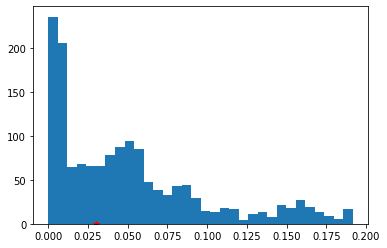

In [207]:
threshold = 0.03

ave_intensities = x_test.mean(axis=-1).mean(axis=-1)
keep_idx = np.where(ave_intensities >= threshold)[0]

plt.hist(ave_intensities, bins=32)
plt.plot([threshold], [0], 'r*')
plt.show()

In [208]:
x_test_filt = x_test[keep_idx]
y_true_filt = y_true[keep_idx]
y_pred_filt = y_pred[keep_idx]

x_test_filt.shape, y_true_filt.shape, y_pred_filt.shape

((879, 894, 894), (1520, 894, 894), (1520, 894, 894))

Pick out ones with large ventricle segmentation volume

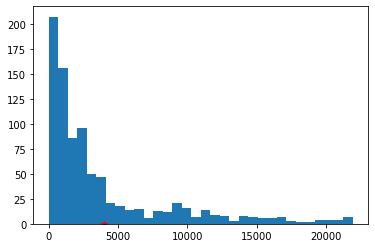

In [220]:
threshold = 4000

ventricle_volumes = y_pred_filt.sum(axis=-1).sum(axis=-1)
keep_idx = np.where(ventricle_volumes >= threshold)[0]

plt.hist(ventricle_volumes, bins=32)
plt.plot([threshold], [0], 'r*')
plt.show()

In [221]:
x_test_filt2 = x_test_filt[keep_idx]
y_true_filt2 = y_true_filt[keep_idx]
y_pred_filt2 = y_pred_filt[keep_idx]

x_test_filt2.shape, y_true_filt2.shape, y_pred_filt2.shape

((242, 894, 894), (242, 894, 894), (242, 894, 894))

In [246]:
working_dir

'/data/datasets/ventricle_segmentation/'

W1112 12:45:22.607215 140261654554432 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W1112 12:45:22.636161 140261654554432 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W1112 12:45:22.683738 140261654554432 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W1112 12:45:22.711440 140261654554432 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W1112 12:45:22.748623 140261654554432 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W1112 12:45:22.772348 140261654554432 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W1112 12:45:22.810985 140261

W1112 12:45:25.041280 140261654554432 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W1112 12:45:25.088741 140261654554432 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W1112 12:45:25.113167 140261654554432 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W1112 12:45:25.160237 140261654554432 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W1112 12:45:25.235689 140261654554432 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W1112 12:45:25.278969 140261654554432 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W1112 12:45:25.345965 140261

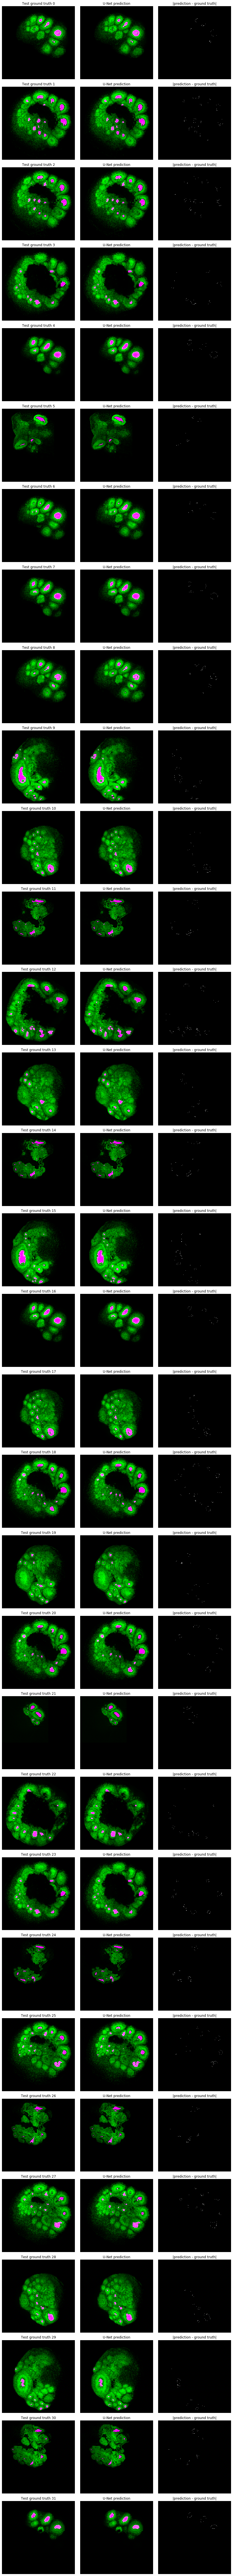

In [255]:
n = 32

idx = np.arange(len(x_test_filt2))
np.random.seed(1)
np.random.shuffle(idx)
idx = idx[:n]

plt.figure(figsize=(12, 4 * n))
for k, i in enumerate(idx):
    plt.subplot(n, 3, 3*k+1)
    plt.imshow(np.dstack([y_true_filt2[i], x_test_filt2[i], y_true_filt2[i]]))
    plt.axis('off')
    plt.title(f'Test ground truth {k}')
    plt.subplot(n, 3, 3*k+2)
    plt.imshow(np.dstack([y_pred_filt2[i], x_test_filt2[i], y_pred_filt2[i]]))
    plt.axis('off')
    plt.title('U-Net prediction')
    plt.subplot(n, 3, 3*k+3)
    plt.imshow(np.abs(y_pred_filt2[i] - y_true_filt2[i]), cmap='gray')
    plt.axis('off')
    plt.title('|prediction - ground truth|')
plt.tight_layout()
plt.savefig(os.path.join(working_dir, 'unet_examples.pdf'), bbox_inches='tight')
plt.show()

7600

In [257]:
len(x_test)

1520

In [ ]:
1520 + 